# CVAE for Missing Modality Reconstruction

**Directory Structure Assumption**

```text
audio_feature_vectors/
├── train-1/
├── train-2/
├── ...
├── val/
└── test/

text_feature_vectors/
├── train-1/
├── train-2/
├── ...
├── val/
└── test/

video_feature_vectors/
├── train-1/
├── train-2/
├── ...
├── val/
└── test/
```



## Download Sample Training Data from Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/My Drive/CSCI535-sample" "/content/"

In [ ]:
import os
os.chdir("/content/CSCI535-sample")

In [ ]:
!ls

audio_small.zip  text_small.zip  video_small.zip


In [ ]:
!unzip video_small.zip -d video_small
!unzip text_small.zip -d text_small
!unzip audio_small.zip -d audio_small

Archive:  video_small.zip
  inflating: video_small/-fqiCqZtgYs.002.npy  
  inflating: video_small/-Gl98Jn45Fs.003.npy  
  inflating: video_small/-IK--4uz5ZY.004.npy  
  inflating: video_small/-55DRRMTppE.005.npy  
  inflating: video_small/-AmMDnVl4s8.003.npy  
  inflating: video_small/--Ymqszjv54.004.npy  
  inflating: video_small/-R2SZu3SYgM.000.npy  
  inflating: video_small/-utrsarZeIY.001.npy  
  inflating: video_small/-VTqcHNgH7M.003.npy  
  inflating: video_small/-Wqk9eex6bQ.003.npy  
  inflating: video_small/-Wqk9eex6bQ.004.npy  
  inflating: video_small/-DOqN0d8KHw.003.npy  
Archive:  text_small.zip
  inflating: text_small/-IK--4uz5ZY.004.npy  
  inflating: text_small/-R2SZu3SYgM.000.npy  
  inflating: text_small/-utrsarZeIY.001.npy  
  inflating: text_small/-55DRRMTppE.005.npy  
  inflating: text_small/-AmMDnVl4s8.003.npy  
  inflating: text_small/-DOqN0d8KHw.003.npy  
  inflating: text_small/--Ymqszjv54.004.npy  
  inflating: text_small/-VTqcHNgH7M.003.npy  
  inflating: text

In [ ]:
!mkdir -p audio_feature_vectors/train-1 text_feature_vectors/train-1 video_feature_vectors/train-1
!mkdir -p audio_feature_vectors/train-2 text_feature_vectors/train-2 video_feature_vectors/train-2

!cp audio_small/*.npy audio_feature_vectors/train-1/
!cp audio_small/*.npy audio_feature_vectors/train-2/
!cp text_small/*.npy text_feature_vectors/train-1/
!cp text_small/*.npy text_feature_vectors/train-2/
!cp video_small/*.npy video_feature_vectors/train-1/
!cp video_small/*.npy video_feature_vectors/train-2/

In [ ]:
import os
import shutil

def copy_folder(src_dir, dst_dir):
    os.makedirs(dst_dir, exist_ok=True)
    for fname in os.listdir(src_dir):
        if fname.endswith('.npy'):
            shutil.copy(os.path.join(src_dir, fname), os.path.join(dst_dir, fname))

copy_folder("audio_feature_vectors/train-1", "audio_feature_vectors/val")
copy_folder("text_feature_vectors/train-1", "text_feature_vectors/val")
copy_folder("video_feature_vectors/train-1", "video_feature_vectors/val")

In [ ]:
!mkdir -p audio_feature_vectors/test text_feature_vectors/test video_feature_vectors/test
!cp audio_feature_vectors/train-2/*.npy audio_feature_vectors/test/
!cp text_feature_vectors/train-2/*.npy text_feature_vectors/test/
!cp video_feature_vectors/train-2/*.npy video_feature_vectors/test/

## Dataset Loader

### Ignore this - doesn't do lazy loading - it would consume too much mem

In [ ]:
# import os
# import numpy as np
# from torch.utils.data import Dataset
# import torch

# class MultimodalFeatureDataset(Dataset):
#     def __init__(self, audio_dir, text_dir, visual_dir):
#         self.audio_dir = audio_dir
#         self.text_dir = text_dir
#         self.visual_dir = visual_dir

#         audio_ids = {f[:-4] for f in os.listdir(audio_dir) if f.endswith(".npy")}
#         text_ids = {f[:-4] for f in os.listdir(text_dir) if f.endswith(".npy")}
#         visual_ids = {f[:-4] for f in os.listdir(visual_dir) if f.endswith(".npy")}
#         self.common_ids = sorted(audio_ids & text_ids & visual_ids)

#     def __len__(self):
#         return len(self.common_ids)

#     def __getitem__(self, idx):
#         sample_id = self.common_ids[idx]

#         # Load .npy files
#         audio = np.load(os.path.join(self.audio_dir, f"{sample_id}.npy"))   # [5, 149, 1024]
#         text = np.load(os.path.join(self.text_dir, f"{sample_id}.npy"))     # [768]
#         visual = np.load(os.path.join(self.visual_dir, f"{sample_id}.npy")) # [5, 1, 512]

#         # Pool within each audio segment (across time) → (5, 1024)
#         audio_segmented = np.mean(audio, axis=1)

#         # Visual: squeeze the singleton frame → (5, 512)
#         visual_segmented = visual.squeeze(1)

#         return {
#             "id": sample_id,
#             "text": torch.tensor(text, dtype=torch.float32),                   # [768]
#             "audio_segments": torch.tensor(audio_segmented, dtype=torch.float32), # [5, 1024]
#             "visual_segments": torch.tensor(visual_segmented, dtype=torch.float32) # [5, 512]
#         }

In [ ]:
# from torch.utils.data import DataLoader

# dataset = MultimodalFeatureDataset(
#     audio_dir="audio_small",
#     text_dir="text_small",
#     visual_dir="video_small"
# )

# loader = DataLoader(dataset, batch_size=4, shuffle=True)

# for batch in loader:
#     print(batch["audio_segments"].shape)   # [B, 5, 1024]
#     print(batch["visual_segments"].shape)  # [B, 5, 512]
#     print(batch["text"].shape)             # [B, 768]
#     break

In [ ]:
# test_audio_dir = "audio_small"
# test_visual_dir = "video_small"
# test_text_dir = "text_small"

# test_dataset = MultimodalFeatureDataset(
#     audio_dir=test_audio_dir,
#     text_dir=test_text_dir,
#     visual_dir=test_visual_dir,
# )

# test_loader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [ ]:
# model = SegmentConditionalVAE(target='visual')
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# train_vae(
#     model=model,
#     train_loader=test_loader,
#     optimizer=optimizer,
#     num_epochs=5,  # keep it short for testing
#     device='cuda' if torch.cuda.is_available() else 'cpu',
#     beta=0.1
# )

### Lazy Loader

In [ ]:
# import os
# import numpy as np
# from torch.utils.data import Dataset
# import torch

# class LazyMultimodalFeatureDataset(Dataset):
#     def __init__(self, audio_root, text_root, visual_root):
#         self.audio_root = audio_root
#         self.text_root = text_root
#         self.visual_root = visual_root

#         # Collect sample IDs and paths across all subfolders
#         self.sample_index = self._build_index()

#     def _build_index(self):
#         index = []
#         # Expecting audio_root/train-1/*.npy and so on
#         for subdir in sorted(os.listdir(self.audio_root)):
#             audio_subdir = os.path.join(self.audio_root, subdir)
#             text_subdir = os.path.join(self.text_root, subdir)
#             visual_subdir = os.path.join(self.visual_root, subdir)

#             if not (os.path.isdir(audio_subdir) and os.path.isdir(text_subdir) and os.path.isdir(visual_subdir)):
#                 continue

#             audio_ids = {f[:-4] for f in os.listdir(audio_subdir) if f.endswith('.npy')}
#             text_ids = {f[:-4] for f in os.listdir(text_subdir) if f.endswith('.npy')}
#             visual_ids = {f[:-4] for f in os.listdir(visual_subdir) if f.endswith('.npy')}
#             common_ids = sorted(audio_ids & text_ids & visual_ids)

#             for sample_id in common_ids:
#                 index.append((
#                     sample_id,
#                     os.path.join(audio_subdir, f"{sample_id}.npy"),
#                     os.path.join(text_subdir, f"{sample_id}.npy"),
#                     os.path.join(visual_subdir, f"{sample_id}.npy"),
#                 ))
#         return index

#     def __len__(self):
#         return len(self.sample_index)

#     def pad_to_segments(self, x, target_segments=5):
#         if x.shape[0] < target_segments:
#             pad_len = target_segments - x.shape[0]
#             pad_shape = (pad_len, *x.shape[1:])
#             pad = np.zeros(pad_shape, dtype=x.dtype)
#             x = np.concatenate([x, pad], axis=0)
#         elif x.shape[0] > target_segments:
#             x = x[:target_segments]
#         return x

#     def __getitem__(self, idx):
#         sample_id, audio_path, text_path, visual_path = self.sample_index[idx]
#         try:
#             audio = np.load(audio_path)
#             if audio.ndim < 2:
#                 raise ValueError(f"Invalid audio shape: {audio.shape}")
#             audio_segments = np.mean(audio, axis=1)
#             audio_segments = self.pad_to_segments(audio_segments, 5)

#         except Exception as e:
#             print(f"Skipping sample {audio_path} due to invalid shape or error: {e}")
#             return self.__getitem__((idx + 1) % len(self))  # next sample

#         # audio = np.load(audio_path)                  # [5, 149, 1024]
#         # audio_segments = np.mean(audio, axis=1)      # [5, 1024]
#         # audio_segments = self.pad_to_segments(audio_segments, 5)

#         text = np.load(text_path)                    # [768]
#         visual = np.load(visual_path)                # [5, 1, 512]
#         visual_segments = visual.squeeze(1)          # [5, 512]
#         visual_segments = self.pad_to_segments(visual_segments, 5)

#         return {
#             "id": sample_id,
#             "audio_segments": torch.tensor(audio_segments, dtype=torch.float32),
#             "visual_segments": torch.tensor(visual_segments, dtype=torch.float32),
#             "text": torch.tensor(text, dtype=torch.float32),
#         }

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset

class MultimodalFeatureDataset(Dataset):
    def __init__(self, audio_root, text_root, visual_root, split='train'):
        self.audio_root = audio_root
        self.text_root = text_root
        self.visual_root = visual_root
        self.split = split

        # Preload all samples into memory
        self.samples = self._preload_data()

    def _collect_sample_paths(self):
        index = []
        for subdir in sorted(os.listdir(self.audio_root)):
            if self.split == 'train' and not subdir.startswith('train-'):
                continue
            if self.split == 'val' and subdir != 'val':
                continue
            if self.split == 'test' and subdir != 'test':
                continue

            audio_subdir = os.path.join(self.audio_root, subdir)
            text_subdir = os.path.join(self.text_root, subdir)
            visual_subdir = os.path.join(self.visual_root, subdir)

            if not (os.path.isdir(audio_subdir) and os.path.isdir(text_subdir) and os.path.isdir(visual_subdir)):
                continue

            audio_ids = {f[:-4] for f in os.listdir(audio_subdir) if f.endswith('.npy')}
            text_ids = {f[:-4] for f in os.listdir(text_subdir) if f.endswith('.npy')}
            visual_ids = {f[:-4] for f in os.listdir(visual_subdir) if f.endswith('.npy')}
            common_ids = sorted(audio_ids & text_ids & visual_ids)

            for sample_id in common_ids:
                index.append((
                    sample_id,
                    os.path.join(audio_subdir, f"{sample_id}.npy"),
                    os.path.join(text_subdir, f"{sample_id}.npy"),
                    os.path.join(visual_subdir, f"{sample_id}.npy"),
                ))
        return index

    def _pad_to_segments(self, x, target_segments=5):
        if x.shape[0] < target_segments:
            pad_len = target_segments - x.shape[0]
            pad_shape = (pad_len, *x.shape[1:])
            pad = np.zeros(pad_shape, dtype=x.dtype)
            x = np.concatenate([x, pad], axis=0)
        elif x.shape[0] > target_segments:
            x = x[:target_segments]
        return x

    def _preload_data(self):
        sample_paths = self._collect_sample_paths()
        samples = []

        for sample_id, audio_path, text_path, visual_path in sample_paths:
            try:
                audio = np.load(audio_path)
                if audio.ndim < 2:
                    raise ValueError(f"Invalid audio shape: {audio.shape}")
                audio_segments = np.mean(audio, axis=1)  # [T, 1024]
                audio_segments = self._pad_to_segments(audio_segments, 5)

                text = np.load(text_path)  # [768]
                visual = np.load(visual_path).squeeze(1)  # [T, 512]
                visual_segments = self._pad_to_segments(visual, 5)

                sample = {
                    "id": sample_id,
                    "audio_segments": torch.tensor(audio_segments, dtype=torch.float32),
                    "visual_segments": torch.tensor(visual_segments, dtype=torch.float32),
                    "text": torch.tensor(text, dtype=torch.float32),
                }
                samples.append(sample)

            except Exception as e:
                print(f"Skipping sample {sample_id} due to error: {e}")
                continue

        return samples

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


In [ ]:
!ls "../../project/msoleyma_1026/personality_detection"

ChaLearn2016_tiny      baseline_audio_files		 text_feature_vectors
ChaLearn2016_tiny.zip  baseline_video_files		 video_feature_vectors
__MACOSX	       combined_text_feature_vector.npy
audio_feature_vectors  first_impressions_v2_dataset


In [ ]:
train_dataset = MultimodalFeatureDataset(
    audio_root="/project/msoleyma_1026/personality_detection/first_impressions_v2_dataset/audio_feature_vectors",
    text_root="/project/msoleyma_1026/personality_detection/first_impressions_v2_dataset/text_feature_vectors",
    visual_root="/project/msoleyma_1026/personality_detection/first_impressions_v2_dataset/video_feature_vectors",
    split='train'
)

train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=4,
    shuffle=True,
    num_workers=0
)

Skipping sample r93dLeVRk3U.003 due to error: Invalid audio shape: (0,)
Skipping sample 39o1zJFeM7E.004 due to error: Invalid audio shape: (0,)


In [ ]:
val_dataset = MultimodalFeatureDataset(
    audio_root="/project/msoleyma_1026/personality_detection/first_impressions_v2_dataset/audio_feature_vectors",
    text_root="/project/msoleyma_1026/personality_detection/first_impressions_v2_dataset/text_feature_vectors",
    visual_root="/project/msoleyma_1026/personality_detection/first_impressions_v2_dataset/video_feature_vectors",
    split='val'
)

# # Filter for val-only data
# val_dataset.sample_index = [
#     s for s in val_dataset.sample_index if '/val/' in s[1]
# ]

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=0
)

In [ ]:
test_dataset = MultimodalFeatureDataset(
    audio_root="/project/msoleyma_1026/personality_detection/first_impressions_v2_dataset/audio_feature_vectors",
    text_root="/project/msoleyma_1026/personality_detection/first_impressions_v2_dataset/text_feature_vectors",
    visual_root="/project/msoleyma_1026/personality_detection/first_impressions_v2_dataset/video_feature_vectors",
    split='test'
)

# # Only use /test/ samples
# test_dataset.sample_index = [s for s in test_dataset.sample_index if '/test/' in s[1]]

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=1,  # Save one at a time
    num_workers=0
)

Skipping sample RhFPotjd0hM.000 due to error: Invalid audio shape: (0,)


# CVAE Model

## Model Definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SegmentConditionalVAE(nn.Module):
    def __init__(self, text_dim=768, audio_dim=1024, visual_dim=512, latent_dim=128, target='visual'):
        super().__init__()

        # Decide which modality is missing (target), and which is available (conditioning)
        self.target = target
        self.latent_dim = latent_dim

        if target == 'visual':
            self.input_modality_dim = audio_dim
            self.output_dim = visual_dim
        elif target == 'audio':
            self.input_modality_dim = visual_dim
            self.output_dim = audio_dim
        else:
            raise ValueError("target must be 'visual' or 'audio'")

        self.segment_dim = 5  # number of segments

        # ------ ENCODER -------
        self.encoder = nn.Sequential(
            nn.Linear(self.input_modality_dim + text_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
        )
        self.fc_mu = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # ------ DECODER -------
        self.decoder_input = nn.Linear(latent_dim + self.input_modality_dim + text_dim, 256)
        self.decoder = nn.Sequential(
        nn.ReLU(),
        nn.Linear(256, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, 512),
        nn.ReLU(),
        nn.Linear(512, self.output_dim)
    )

    def encode(self, condition_segments, text):
        """
        Encode the conditioning modality + text into μ and logσ²
        """
        B, T, _ = condition_segments.shape
        text = text.unsqueeze(1).expand(-1, T, -1)  # (B, 5, 768)
        concat = torch.cat([condition_segments, text], dim=-1)  # (B, 5, cond+768)
        hidden = self.encoder(concat)                # (B, 5, 256)
        mu = self.fc_mu(hidden)                      # (B, 5, latent_dim)
        logvar = self.fc_logvar(hidden)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        """
        Sample z from N(μ, σ²) using the reparameterization trick
        """
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, condition_segments, text):
        """
        Decode the latent z with conditioning inputs into reconstructed output
        """
        B, T, _ = z.shape
        text = text.unsqueeze(1).expand(-1, T, -1)  # (B, 5, 768)
        dec_input = torch.cat([z, condition_segments, text], dim=-1)  # (B, 5, latent+cond+text)
        dec_input = self.decoder_input(dec_input)  # (B, 5, 256)
        out = self.decoder(dec_input)              # (B, 5, output_dim)
        return out

    def forward(self, condition_segments, text, use_mean=False):
        """
        Forward pass for training or inference.

        Args:
            condition_segments: (B, T, input_modality_dim)
            text: (B, 768)
            use_mean (bool): If True, use z = μ. Otherwise, sample using z = μ + σ * ε

        Returns:
            out: reconstructed modality
            mu, logvar: latent distribution parameters
        """
        mu, logvar = self.encode(condition_segments, text)

        # Safety: warn if use_mean=True during training (not recommended)
        if self.training and use_mean:
            print("[Warning] use_mean=True during training — model will behave deterministically. "
                  "You probably want to set use_mean=False for stochastic training.")

        if use_mean:
            z = mu
        else:
            z = self.reparameterize(mu, logvar)

        out = self.decode(z, condition_segments, text)
        return out, mu, logvar


    def sample_from_prior(self, condition_segments, text):
        """
        Pure generative inference: sample z ~ N(0, I), no encoder needed.
        """
        B, T, _ = condition_segments.shape
        z = torch.randn((B, T, self.latent_dim), device=condition_segments.device)
        out = self.decode(z, condition_segments, text)
        return out


## Training Pipeline

In [ ]:
import torch
import torch.nn.functional as F
from tqdm import tqdm

def compute_kl_loss(mu, logvar):
    """KL divergence per batch"""
    return -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp()) / mu.shape[0]

def validate(model, val_loader, device='cuda'):
    """Evaluate reconstruction loss (MSE) on validation set"""
    model.eval()
    total_recon_loss = 0.0
    total_samples = 0

    with torch.no_grad():
        for batch in val_loader:
            text = batch["text"].to(device)
            if model.target == "visual":
                condition = batch["audio_segments"].to(device)
                target = batch["visual_segments"].to(device)
            else:
                condition = batch["visual_segments"].to(device)
                target = batch["audio_segments"].to(device)

            output, _, _ = model(condition, text, use_mean=True)  # Deterministic for validation
            loss = F.mse_loss(output, target, reduction='sum')
            total_recon_loss += loss.item()
            total_samples += target.numel()

    model.train()
    return total_recon_loss / total_samples

def save_checkpoint(model, optimizer, epoch, path="checkpoint.pt"):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(checkpoint, path)

def train_vae(
    model,
    train_loader,
    optimizer,
    num_epochs=10,
    device='cuda',
    initial_beta=0.0,
    max_beta=1.0,
    beta_anneal_epochs=10,
    val_loader=None,
    save_path="best_model.pt",
    patience=5,
    scheduler=None
):
    model.to(device)
    model.train()

    best_val_loss = float("inf")
    epochs_no_improve = 0

    for epoch in range(1, num_epochs + 1):
        model.train()
        total_recon_loss = 0
        total_kl_loss = 0
        total_cosine_loss = 0
        total_loss = 0

        # --- KL Annealing ---
        beta = min(max_beta, initial_beta + (max_beta - initial_beta) * (epoch / beta_anneal_epochs))

        for batch in tqdm(train_loader, desc=f"Epoch {epoch}"):
            optimizer.zero_grad()

            text = batch["text"].to(device)
            if model.target == "visual":
                condition = batch["audio_segments"].to(device)
                target = batch["visual_segments"].to(device)
            else:
                condition = batch["visual_segments"].to(device)
                target = batch["audio_segments"].to(device)

            output, mu, logvar = model(condition, text, use_mean=False)

            recon_loss = F.mse_loss(output, target, reduction='mean')
            kl_loss = compute_kl_loss(mu, logvar)
            cosine_loss = 1 - F.cosine_similarity(output, target, dim=-1).mean()
            loss = recon_loss + beta * kl_loss + 0.1*cosine_loss

            loss.backward()
            optimizer.step()

            total_recon_loss += recon_loss.item()
            total_kl_loss += kl_loss.item()
            total_cosine_loss+= cosine_loss.item()
            total_loss += loss.item()

        # print("mu mean:", mu.mean().item(), "mu std:", mu.std().item())
        # print("logvar mean:", logvar.mean().item())

        print(f"Epoch {epoch}: Recon Loss = {total_recon_loss:.4f}, KL Loss = {total_kl_loss:.4f}, Cosine Loss = {total_cosine_loss:.4f}, Total Loss = {total_loss:.4f}, Beta = {beta:.4f}")

        # --- Validation step ---
        if val_loader:
            val_loss = validate(model, val_loader, device)
            print(f"Validation MSE: {val_loss:.6f}")

            if val_loss < best_val_loss:
                best_val_loss = val_loss
                epochs_no_improve = 0
                torch.save(model.state_dict(), save_path)
                print(f"Saved best model at epoch {epoch}.")
            else:
                epochs_no_improve += 1
                print(f"No improvement for {epochs_no_improve} epoch(s).")

            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

        # --- LR Annealing Step ---
        if scheduler is not None:
            scheduler.step()



## Train and Save Model

In [ ]:
target = 'visual'
model = SegmentConditionalVAE(target=target)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# LR Scheduler: Reduce LR by 0.5 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_vae(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    num_epochs=50,
    val_loader=val_loader,
    initial_beta=0.0,          # KL starts off 0
    max_beta=0.01,             # KL reaches 0.01 (for gentle regularization)
    beta_anneal_epochs=10,     # Over first 10 epochs
    save_path=f"cvae_{target}_beta_anneal.pt",
    patience=10,
    scheduler=scheduler
)

Epoch 1: 100%|██████████| 1500/1500 [00:02<00:00, 521.73it/s]


Epoch 1: Recon Loss = 0.1198, KL Loss = 10.5797, Cosine Loss = 22.9313, Total Loss = 2.4235, Beta = 0.0010
Validation MSE: 0.000052
Saved best model at epoch 1.


Epoch 2: 100%|██████████| 1500/1500 [00:02<00:00, 549.01it/s]


Epoch 2: Recon Loss = 0.0712, KL Loss = 0.1773, Cosine Loss = 18.1893, Total Loss = 1.8905, Beta = 0.0020
Validation MSE: 0.000045
Saved best model at epoch 2.


Epoch 3: 100%|██████████| 1500/1500 [00:02<00:00, 549.04it/s]


Epoch 3: Recon Loss = 0.0696, KL Loss = 0.0571, Cosine Loss = 17.8133, Total Loss = 1.8511, Beta = 0.0030
Validation MSE: 0.000049
No improvement for 1 epoch(s).


Epoch 4: 100%|██████████| 1500/1500 [00:02<00:00, 550.17it/s]


Epoch 4: Recon Loss = 0.0689, KL Loss = 0.0023, Cosine Loss = 17.6505, Total Loss = 1.8340, Beta = 0.0040
Validation MSE: 0.000047
No improvement for 2 epoch(s).


Epoch 5: 100%|██████████| 1500/1500 [00:02<00:00, 549.93it/s]


Epoch 5: Recon Loss = 0.0684, KL Loss = 0.0023, Cosine Loss = 17.5332, Total Loss = 1.8217, Beta = 0.0050
Validation MSE: 0.000048
No improvement for 3 epoch(s).


Epoch 6: 100%|██████████| 1500/1500 [00:02<00:00, 550.25it/s]


Epoch 6: Recon Loss = 0.0671, KL Loss = 0.0025, Cosine Loss = 17.2451, Total Loss = 1.7916, Beta = 0.0060
Validation MSE: 0.000044
Saved best model at epoch 6.


Epoch 7: 100%|██████████| 1500/1500 [00:02<00:00, 550.76it/s]


Epoch 7: Recon Loss = 0.0671, KL Loss = 0.0029, Cosine Loss = 17.2722, Total Loss = 1.7944, Beta = 0.0070
Validation MSE: 0.000044
Saved best model at epoch 7.


Epoch 8: 100%|██████████| 1500/1500 [00:02<00:00, 551.71it/s]


Epoch 8: Recon Loss = 0.0670, KL Loss = 0.0027, Cosine Loss = 17.2450, Total Loss = 1.7916, Beta = 0.0080
Validation MSE: 0.000044
No improvement for 1 epoch(s).


Epoch 9: 100%|██████████| 1500/1500 [00:02<00:00, 552.46it/s]


Epoch 9: Recon Loss = 0.0670, KL Loss = 0.0028, Cosine Loss = 17.2416, Total Loss = 1.7912, Beta = 0.0090
Validation MSE: 0.000044
Saved best model at epoch 9.


Epoch 10: 100%|██████████| 1500/1500 [00:02<00:00, 553.42it/s]


Epoch 10: Recon Loss = 0.0670, KL Loss = 0.0030, Cosine Loss = 17.2271, Total Loss = 1.7897, Beta = 0.0100
Validation MSE: 0.000045
No improvement for 1 epoch(s).


Epoch 11: 100%|██████████| 1500/1500 [00:02<00:00, 554.53it/s]


Epoch 11: Recon Loss = 0.0664, KL Loss = 0.0020, Cosine Loss = 17.0910, Total Loss = 1.7755, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 2 epoch(s).


Epoch 12: 100%|██████████| 1500/1500 [00:02<00:00, 550.87it/s]


Epoch 12: Recon Loss = 0.0664, KL Loss = 0.0035, Cosine Loss = 17.1003, Total Loss = 1.7765, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 3 epoch(s).


Epoch 13: 100%|██████████| 1500/1500 [00:02<00:00, 554.86it/s]


Epoch 13: Recon Loss = 0.0666, KL Loss = 0.0035, Cosine Loss = 17.1339, Total Loss = 1.7800, Beta = 0.0100
Validation MSE: 0.000044
Saved best model at epoch 13.


Epoch 14: 100%|██████████| 1500/1500 [00:02<00:00, 554.05it/s]


Epoch 14: Recon Loss = 0.0664, KL Loss = 0.0035, Cosine Loss = 17.0911, Total Loss = 1.7755, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 1 epoch(s).


Epoch 15: 100%|██████████| 1500/1500 [00:02<00:00, 554.00it/s]


Epoch 15: Recon Loss = 0.0665, KL Loss = 0.0036, Cosine Loss = 17.1067, Total Loss = 1.7772, Beta = 0.0100
Validation MSE: 0.000044
Saved best model at epoch 15.


Epoch 16: 100%|██████████| 1500/1500 [00:02<00:00, 553.99it/s]


Epoch 16: Recon Loss = 0.0662, KL Loss = 0.0021, Cosine Loss = 17.0327, Total Loss = 1.7695, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 1 epoch(s).


Epoch 17: 100%|██████████| 1500/1500 [00:02<00:00, 554.11it/s]


Epoch 17: Recon Loss = 0.0662, KL Loss = 0.0023, Cosine Loss = 17.0460, Total Loss = 1.7708, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 2 epoch(s).


Epoch 18: 100%|██████████| 1500/1500 [00:02<00:00, 554.23it/s]


Epoch 18: Recon Loss = 0.0662, KL Loss = 0.0022, Cosine Loss = 17.0347, Total Loss = 1.7697, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 3 epoch(s).


Epoch 19: 100%|██████████| 1500/1500 [00:02<00:00, 553.72it/s]


Epoch 19: Recon Loss = 0.0662, KL Loss = 0.0023, Cosine Loss = 17.0384, Total Loss = 1.7701, Beta = 0.0100
Validation MSE: 0.000044
Saved best model at epoch 19.


Epoch 20: 100%|██████████| 1500/1500 [00:02<00:00, 552.76it/s]


Epoch 20: Recon Loss = 0.0662, KL Loss = 0.0020, Cosine Loss = 17.0435, Total Loss = 1.7706, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 1 epoch(s).


Epoch 21: 100%|██████████| 1500/1500 [00:02<00:00, 552.07it/s]


Epoch 21: Recon Loss = 0.0661, KL Loss = 0.0020, Cosine Loss = 17.0111, Total Loss = 1.7672, Beta = 0.0100
Validation MSE: 0.000044
Saved best model at epoch 21.


Epoch 22: 100%|██████████| 1500/1500 [00:02<00:00, 550.63it/s]


Epoch 22: Recon Loss = 0.0660, KL Loss = 0.0013, Cosine Loss = 16.9987, Total Loss = 1.7659, Beta = 0.0100
Validation MSE: 0.000044
Saved best model at epoch 22.


Epoch 23: 100%|██████████| 1500/1500 [00:02<00:00, 551.84it/s]


Epoch 23: Recon Loss = 0.0660, KL Loss = 0.0017, Cosine Loss = 16.9907, Total Loss = 1.7651, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 1 epoch(s).


Epoch 24: 100%|██████████| 1500/1500 [00:02<00:00, 551.27it/s]


Epoch 24: Recon Loss = 0.0659, KL Loss = 0.0022, Cosine Loss = 16.9717, Total Loss = 1.7631, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 2 epoch(s).


Epoch 25: 100%|██████████| 1500/1500 [00:02<00:00, 550.31it/s]


Epoch 25: Recon Loss = 0.0660, KL Loss = 0.0033, Cosine Loss = 16.9925, Total Loss = 1.7653, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 3 epoch(s).


Epoch 26: 100%|██████████| 1500/1500 [00:02<00:00, 549.49it/s]


Epoch 26: Recon Loss = 0.0659, KL Loss = 0.0030, Cosine Loss = 16.9444, Total Loss = 1.7603, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 4 epoch(s).


Epoch 27: 100%|██████████| 1500/1500 [00:02<00:00, 550.12it/s]


Epoch 27: Recon Loss = 0.0657, KL Loss = 0.0041, Cosine Loss = 16.8995, Total Loss = 1.7557, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 5 epoch(s).


Epoch 28: 100%|██████████| 1500/1500 [00:02<00:00, 547.69it/s]


Epoch 28: Recon Loss = 0.0656, KL Loss = 0.0044, Cosine Loss = 16.8688, Total Loss = 1.7526, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 6 epoch(s).


Epoch 29: 100%|██████████| 1500/1500 [00:02<00:00, 547.91it/s]


Epoch 29: Recon Loss = 0.0655, KL Loss = 0.0045, Cosine Loss = 16.8319, Total Loss = 1.7487, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 7 epoch(s).


Epoch 30: 100%|██████████| 1500/1500 [00:02<00:00, 550.13it/s]


Epoch 30: Recon Loss = 0.0654, KL Loss = 0.0047, Cosine Loss = 16.7933, Total Loss = 1.7447, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 8 epoch(s).


Epoch 31: 100%|██████████| 1500/1500 [00:02<00:00, 549.65it/s]


Epoch 31: Recon Loss = 0.0650, KL Loss = 0.0045, Cosine Loss = 16.7029, Total Loss = 1.7354, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 9 epoch(s).


Epoch 32: 100%|██████████| 1500/1500 [00:02<00:00, 549.40it/s]


Epoch 32: Recon Loss = 0.0649, KL Loss = 0.0045, Cosine Loss = 16.6580, Total Loss = 1.7307, Beta = 0.0100
Validation MSE: 0.000044
No improvement for 10 epoch(s).
Early stopping triggered.


In [ ]:
# target_ = 'audio'
# model = SegmentConditionalVAE(target=target_)
# optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
# beta_ = 0.1

# train_vae(
#     model=model,
#     train_loader=train_loader,
#     optimizer=optimizer,
#     num_epochs=20,
#     val_loader=val_loader,
#     beta=beta_,
#     save_path=f"cvae_{target_}_{beta_}.pt",
#     patience=3,
# )

target_ = 'audio'
model = SegmentConditionalVAE(target=target_)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# LR Scheduler: Reduce LR by 0.5 every 5 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

train_vae(
    model=model,
    train_loader=train_loader,
    optimizer=optimizer,
    num_epochs=50,
    val_loader=val_loader,
    initial_beta=0.0,          # KL starts off 0
    max_beta=0.01,             # KL reaches 0.01 (for gentle regularization)
    beta_anneal_epochs=10,     # Over first 10 epochs
    save_path=f"cvae_{target_}_beta_anneal.pt",
    patience=10,
    scheduler=scheduler
)

Epoch 1: 100%|██████████| 1500/1500 [00:02<00:00, 549.31it/s]


Epoch 1: Recon Loss = 94.9649, KL Loss = 10.9525, Cosine Loss = 915.8310, Total Loss = 186.5590, Beta = 0.0010
Validation MSE: 0.062274
Saved best model at epoch 1.


Epoch 2: 100%|██████████| 1500/1500 [00:02<00:00, 546.91it/s]


Epoch 2: Recon Loss = 94.6517, KL Loss = 0.7281, Cosine Loss = 911.7029, Total Loss = 185.8235, Beta = 0.0020
Validation MSE: 0.062485
No improvement for 1 epoch(s).


Epoch 3: 100%|██████████| 1500/1500 [00:02<00:00, 545.81it/s]


Epoch 3: Recon Loss = 94.5937, KL Loss = 0.3931, Cosine Loss = 911.3649, Total Loss = 185.7314, Beta = 0.0030
Validation MSE: 0.062506
No improvement for 2 epoch(s).


Epoch 4: 100%|██████████| 1500/1500 [00:02<00:00, 546.22it/s]


Epoch 4: Recon Loss = 94.3004, KL Loss = 1.3447, Cosine Loss = 907.9084, Total Loss = 185.0967, Beta = 0.0040
Validation MSE: 0.062087
Saved best model at epoch 4.


Epoch 5: 100%|██████████| 1500/1500 [00:02<00:00, 545.58it/s]


Epoch 5: Recon Loss = 93.8992, KL Loss = 1.4581, Cosine Loss = 902.5832, Total Loss = 184.1648, Beta = 0.0050
Validation MSE: 0.061936
Saved best model at epoch 5.


Epoch 6: 100%|██████████| 1500/1500 [00:02<00:00, 547.17it/s]


Epoch 6: Recon Loss = 93.4407, KL Loss = 0.5823, Cosine Loss = 895.0014, Total Loss = 182.9443, Beta = 0.0060
Validation MSE: 0.061768
Saved best model at epoch 6.


Epoch 7: 100%|██████████| 1500/1500 [00:02<00:00, 548.26it/s]


Epoch 7: Recon Loss = 93.1504, KL Loss = 0.4908, Cosine Loss = 891.1504, Total Loss = 182.2688, Beta = 0.0070
Validation MSE: 0.061792
No improvement for 1 epoch(s).


Epoch 8: 100%|██████████| 1500/1500 [00:02<00:00, 548.15it/s]


Epoch 8: Recon Loss = 92.9970, KL Loss = 0.4874, Cosine Loss = 888.4299, Total Loss = 181.8439, Beta = 0.0080
Validation MSE: 0.061917
No improvement for 2 epoch(s).


Epoch 9: 100%|██████████| 1500/1500 [00:02<00:00, 548.85it/s]


Epoch 9: Recon Loss = 92.8268, KL Loss = 0.3857, Cosine Loss = 885.7268, Total Loss = 181.4029, Beta = 0.0090
Validation MSE: 0.061807
No improvement for 3 epoch(s).


Epoch 10: 100%|██████████| 1500/1500 [00:02<00:00, 548.11it/s]


Epoch 10: Recon Loss = 92.6327, KL Loss = 0.3453, Cosine Loss = 883.2518, Total Loss = 180.9613, Beta = 0.0100
Validation MSE: 0.061813
No improvement for 4 epoch(s).


Epoch 11: 100%|██████████| 1500/1500 [00:02<00:00, 549.43it/s]


Epoch 11: Recon Loss = 92.2416, KL Loss = 0.1761, Cosine Loss = 877.6806, Total Loss = 180.0115, Beta = 0.0100
Validation MSE: 0.061648
Saved best model at epoch 11.


Epoch 12: 100%|██████████| 1500/1500 [00:02<00:00, 548.68it/s]


Epoch 12: Recon Loss = 92.0356, KL Loss = 0.1982, Cosine Loss = 874.4416, Total Loss = 179.4817, Beta = 0.0100
Validation MSE: 0.061630
Saved best model at epoch 12.


Epoch 13: 100%|██████████| 1500/1500 [00:02<00:00, 548.36it/s]


Epoch 13: Recon Loss = 91.7910, KL Loss = 0.2068, Cosine Loss = 871.4684, Total Loss = 178.9399, Beta = 0.0100
Validation MSE: 0.061640
No improvement for 1 epoch(s).


Epoch 14: 100%|██████████| 1500/1500 [00:02<00:00, 548.83it/s]


Epoch 14: Recon Loss = 91.6034, KL Loss = 0.2246, Cosine Loss = 869.0198, Total Loss = 178.5076, Beta = 0.0100
Validation MSE: 0.061599
Saved best model at epoch 14.


Epoch 15: 100%|██████████| 1500/1500 [00:02<00:00, 548.85it/s]


Epoch 15: Recon Loss = 91.3344, KL Loss = 0.2235, Cosine Loss = 865.5206, Total Loss = 177.8887, Beta = 0.0100
Validation MSE: 0.061412
Saved best model at epoch 15.


Epoch 16: 100%|██████████| 1500/1500 [00:02<00:00, 550.62it/s]


Epoch 16: Recon Loss = 90.9894, KL Loss = 0.1283, Cosine Loss = 860.8479, Total Loss = 177.0755, Beta = 0.0100
Validation MSE: 0.061534
No improvement for 1 epoch(s).


Epoch 17: 100%|██████████| 1500/1500 [00:02<00:00, 551.01it/s]


Epoch 17: Recon Loss = 90.7945, KL Loss = 0.1273, Cosine Loss = 857.9239, Total Loss = 176.5882, Beta = 0.0100
Validation MSE: 0.061648
No improvement for 2 epoch(s).


Epoch 18: 100%|██████████| 1500/1500 [00:02<00:00, 549.91it/s]


Epoch 18: Recon Loss = 90.5655, KL Loss = 0.1251, Cosine Loss = 855.3311, Total Loss = 176.0999, Beta = 0.0100
Validation MSE: 0.061726
No improvement for 3 epoch(s).


Epoch 19: 100%|██████████| 1500/1500 [00:02<00:00, 549.56it/s]


Epoch 19: Recon Loss = 90.3715, KL Loss = 0.1491, Cosine Loss = 852.4138, Total Loss = 175.6143, Beta = 0.0100
Validation MSE: 0.061514
No improvement for 4 epoch(s).


Epoch 20: 100%|██████████| 1500/1500 [00:02<00:00, 550.40it/s]


Epoch 20: Recon Loss = 90.2204, KL Loss = 0.1472, Cosine Loss = 850.6918, Total Loss = 175.2911, Beta = 0.0100
Validation MSE: 0.061343
Saved best model at epoch 20.


Epoch 21: 100%|██████████| 1500/1500 [00:02<00:00, 549.57it/s]


Epoch 21: Recon Loss = 89.7629, KL Loss = 0.0714, Cosine Loss = 844.9254, Total Loss = 174.2561, Beta = 0.0100
Validation MSE: 0.061362
No improvement for 1 epoch(s).


Epoch 22: 100%|██████████| 1500/1500 [00:02<00:00, 549.29it/s]


Epoch 22: Recon Loss = 89.5918, KL Loss = 0.0802, Cosine Loss = 842.3423, Total Loss = 173.8269, Beta = 0.0100
Validation MSE: 0.061353
No improvement for 2 epoch(s).


Epoch 23: 100%|██████████| 1500/1500 [00:02<00:00, 548.77it/s]


Epoch 23: Recon Loss = 89.3986, KL Loss = 0.0737, Cosine Loss = 839.8288, Total Loss = 173.3822, Beta = 0.0100
Validation MSE: 0.061325
Saved best model at epoch 23.


Epoch 24: 100%|██████████| 1500/1500 [00:02<00:00, 548.33it/s]


Epoch 24: Recon Loss = 89.3072, KL Loss = 0.0712, Cosine Loss = 838.1702, Total Loss = 173.1249, Beta = 0.0100
Validation MSE: 0.061390
No improvement for 1 epoch(s).


Epoch 25: 100%|██████████| 1500/1500 [00:02<00:00, 547.84it/s]


Epoch 25: Recon Loss = 89.0956, KL Loss = 0.0688, Cosine Loss = 836.3480, Total Loss = 172.7311, Beta = 0.0100
Validation MSE: 0.061488
No improvement for 2 epoch(s).


Epoch 26: 100%|██████████| 1500/1500 [00:02<00:00, 547.41it/s]


Epoch 26: Recon Loss = 88.8524, KL Loss = 0.0427, Cosine Loss = 832.9143, Total Loss = 172.1443, Beta = 0.0100
Validation MSE: 0.061424
No improvement for 3 epoch(s).


Epoch 27: 100%|██████████| 1500/1500 [00:02<00:00, 544.39it/s]


Epoch 27: Recon Loss = 88.7235, KL Loss = 0.0477, Cosine Loss = 831.4061, Total Loss = 171.8645, Beta = 0.0100
Validation MSE: 0.061613
No improvement for 4 epoch(s).


Epoch 28: 100%|██████████| 1500/1500 [00:02<00:00, 546.75it/s]


Epoch 28: Recon Loss = 88.6785, KL Loss = 0.0412, Cosine Loss = 830.1437, Total Loss = 171.6933, Beta = 0.0100
Validation MSE: 0.061391
No improvement for 5 epoch(s).


Epoch 29: 100%|██████████| 1500/1500 [00:02<00:00, 547.65it/s]


Epoch 29: Recon Loss = 88.6129, KL Loss = 0.0455, Cosine Loss = 830.0378, Total Loss = 171.6171, Beta = 0.0100
Validation MSE: 0.061536
No improvement for 6 epoch(s).


Epoch 30: 100%|██████████| 1500/1500 [00:02<00:00, 547.20it/s]


Epoch 30: Recon Loss = 88.5184, KL Loss = 0.0424, Cosine Loss = 828.6418, Total Loss = 171.3830, Beta = 0.0100
Validation MSE: 0.061402
No improvement for 7 epoch(s).


Epoch 31: 100%|██████████| 1500/1500 [00:02<00:00, 547.05it/s]


Epoch 31: Recon Loss = 88.4169, KL Loss = 0.0257, Cosine Loss = 827.2353, Total Loss = 171.1407, Beta = 0.0100
Validation MSE: 0.061494
No improvement for 8 epoch(s).


Epoch 32: 100%|██████████| 1500/1500 [00:02<00:00, 546.60it/s]


Epoch 32: Recon Loss = 88.3385, KL Loss = 0.0227, Cosine Loss = 826.3336, Total Loss = 170.9721, Beta = 0.0100
Validation MSE: 0.061506
No improvement for 9 epoch(s).


Epoch 33: 100%|██████████| 1500/1500 [00:02<00:00, 546.82it/s]


Epoch 33: Recon Loss = 88.3259, KL Loss = 0.0253, Cosine Loss = 825.8347, Total Loss = 170.9096, Beta = 0.0100
Validation MSE: 0.061509
No improvement for 10 epoch(s).
Early stopping triggered.


# Reconstruct Missing Modality

## Load Model

In [ ]:
target_

'audio'

In [ ]:
model = SegmentConditionalVAE(target=target)
# model.load_state_dict(torch.load(f"cvae_{target}_{beta}.pt"))
model.load_state_dict(torch.load("cvae_visual_beta_anneal.pt"))
model.eval()
model.to('cuda' if torch.cuda.is_available() else 'cpu')

SegmentConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=1792, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=128, bias=True)
  (decoder_input): Linear(in_features=1920, out_features=256, bias=True)
  (decoder): Sequential(
    (0): ReLU()
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=512, bias=True)
  )
)

In [ ]:
model_ = SegmentConditionalVAE(target=target_)
# model_.load_state_dict(torch.load(f"cvae_{target_}_{beta_}.pt"))
model_.load_state_dict(torch.load("cvae_audio_beta_anneal.pt"))
model_.eval()
model_.to('cuda' if torch.cuda.is_available() else 'cpu')

SegmentConditionalVAE(
  (encoder): Sequential(
    (0): Linear(in_features=1280, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=256, bias=True)
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=256, out_features=128, bias=True)
  (fc_logvar): Linear(in_features=256, out_features=128, bias=True)
  (decoder_input): Linear(in_features=1408, out_features=256, bias=True)
  (decoder): Sequential(
    (0): ReLU()
    (1): Linear(in_features=256, out_features=512, bias=True)
    (2): ReLU()
    (3): Linear(in_features=512, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=512, bias=True)
    (6): ReLU()
    (7): Linear(in_features=512, out_features=1024, bias=True)
  )
)

In [ ]:
import os
import numpy as np

save_dir = "reconstructed_visual_feature_vectors"
os.makedirs(save_dir, exist_ok=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

with torch.no_grad():
    for batch in test_loader:
        text = batch["text"].to(device)
        audio = batch["audio_segments"].to(device)
        sample_id = batch["id"][0]

        # Reconstruct visual features using deterministic μ
        visual_hat, _, _ = model(audio, text, use_mean=True)
        visual_hat_np = visual_hat.cpu().numpy()  # shape: [1, 5, 512]

        # Convert to shape [5, 1, 512] to match original format
        visual_hat_np = visual_hat_np.reshape(5, 1, 512)

        # Save to .npy
        np.save(os.path.join(save_dir, f"{sample_id}.npy"), visual_hat_np)


In [ ]:
import os
import numpy as np
import torch

save_dir = "reconstructed_audio_feature_vectors"
os.makedirs(save_dir, exist_ok=True)

# model = SegmentConditionalVAE(target='audio')
# model.load_state_dict(torch.load("cvae_audio.pt"))
# model.eval()
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model.to(device)

with torch.no_grad():
    for batch in test_loader:
        text = batch["text"].to(device)
        visual = batch["visual_segments"].to(device)
        sample_id = batch["id"][0]

        # Reconstruct audio features using deterministic μ
        audio_hat, _, _ = model_(visual, text, use_mean=True)
        audio_hat_np = audio_hat.cpu().numpy()  # e.g., shape [1, 5, 1024]

        # Dynamically reshape to [5, 1, feature_dim]
        audio_hat_np = audio_hat_np.reshape(audio_hat_np.shape[1], 1, audio_hat_np.shape[2])

        # Save to .npy file
        np.save(os.path.join(save_dir, f"{sample_id}.npy"), audio_hat_np)
# import os
# import numpy as np

# save_dir = "reconstructed_audio_feature_vectors"
# os.makedirs(save_dir, exist_ok=True)

# model = SegmentConditionalVAE(target='audio')
# model.load_state_dict(torch.load("cvae_audio.pt"))
# model.eval()
# model.to('cuda' if torch.cuda.is_available() else 'cpu')

# device = 'cuda' if torch.cuda.is_available() else 'cpu'

# with torch.no_grad():
#     for batch in test_loader:
#         # print(batch)
#         text = batch["text"].to(device)
#         visual = batch["visual_segments"].to(device)
#         sample_id = batch["id"][0]

#         # Reconstruct visual features using deterministic μ
#         visual_hat, _, _ = model(audio, text, use_mean=True)
#         visual_hat_np = visual_hat.cpu().numpy()  # shape: [1, 5, 512]

#         # Convert to shape [5, 1, 512] to match original format
#         visual_hat_np = visual_hat_np.reshape(5, 1, 512)

#         # Save to .npy
#         np.save(os.path.join(save_dir, f"{sample_id}.npy"), visual_hat_np)


## Reconstruct, Save feats and Plot T-SNE

In [ ]:
import sys
print(sys.version)

3.11.9 (main, Jun  4 2024, 14:22:24) [GCC 13.3.0]


In [ ]:
import sys
print(sys.executable)

/apps/spack/2406/apps/linux-rocky8-x86_64_v3/gcc-13.3.0/python-3.11.9-x74mtjf/bin/python


In [ ]:
!{sys.executable} -m pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 10.5 MB/s eta 0:00:00
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 48.5 MB/s eta 0:00:00:00:0100:01
Using cached joblib-1.4.2-py3-none-any.whl (301 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.6/37.6 MB 24.1 MB/s eta 0:00:00:00:0100:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /apps/spack/2406/apps/linux-rocky8-x86_64_v3/gcc-13.3.0/python-3.11.9-x74mtjf/bin/python -m pip install --upgrade pip


In [ ]:
!{sys.executable} -m pip install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.5/102.5 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 57.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 56.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 55.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 56.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 25.9 MB/s eta 0:00:00
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: /apps/spack/2406/apps/linux-rocky8-x86_64_v3/gcc-13.3.0/python-3.11.9-x74mtjf/bin/python -m pip install --upgrade pip


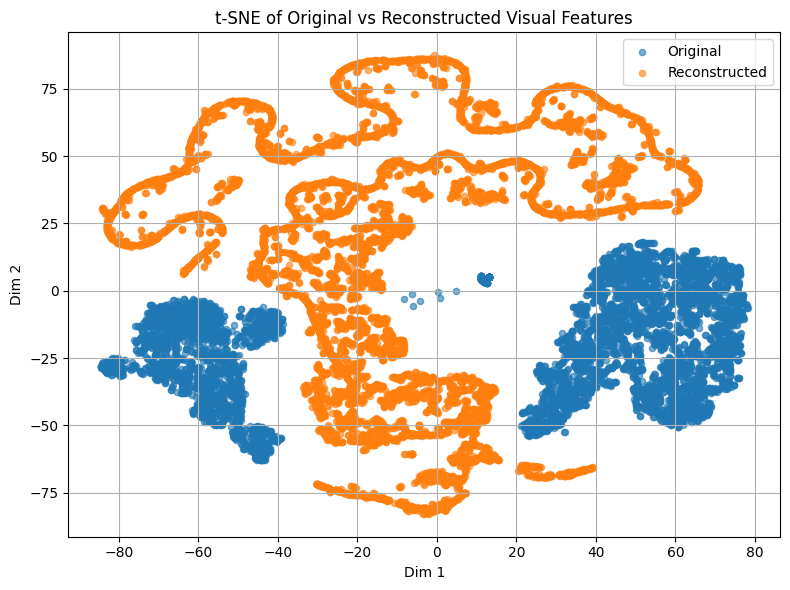

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os

original_dir = "video_feature_vectors/test"
recon_dir = "reconstructed_visual_feature_vectors"

original_feats = []
recon_feats = []
labels = []

for fname in sorted(os.listdir(recon_dir)):
    if not fname.endswith(".npy"):
        continue

    sample_id = fname[:-4]
    orig_path = os.path.join(original_dir, fname)
    recon_path = os.path.join(recon_dir, fname)

    if not os.path.exists(orig_path):
        continue

    original = np.load(orig_path).squeeze(1)       # [5, 512]
    recon = np.load(recon_path).squeeze(1)         # [5, 512]

    if original.shape != recon.shape:
        continue

    original_feats.extend(original)
    recon_feats.extend(recon)

# Combine and label
X = np.vstack([original_feats, recon_feats])  # [N*2, 512]
y = np.array([0]*len(original_feats) + [1]*len(recon_feats))  # 0 = original, 1 = recon

# t-SNE embedding
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=42)
X_2d = tsne.fit_transform(X)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[y==0, 0], X_2d[y==0, 1], label="Original", alpha=0.6, s=20)
plt.scatter(X_2d[y==1, 0], X_2d[y==1, 1], label="Reconstructed", alpha=0.6, s=20)
plt.legend()
plt.title("t-SNE of Original vs Reconstructed Visual Features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()


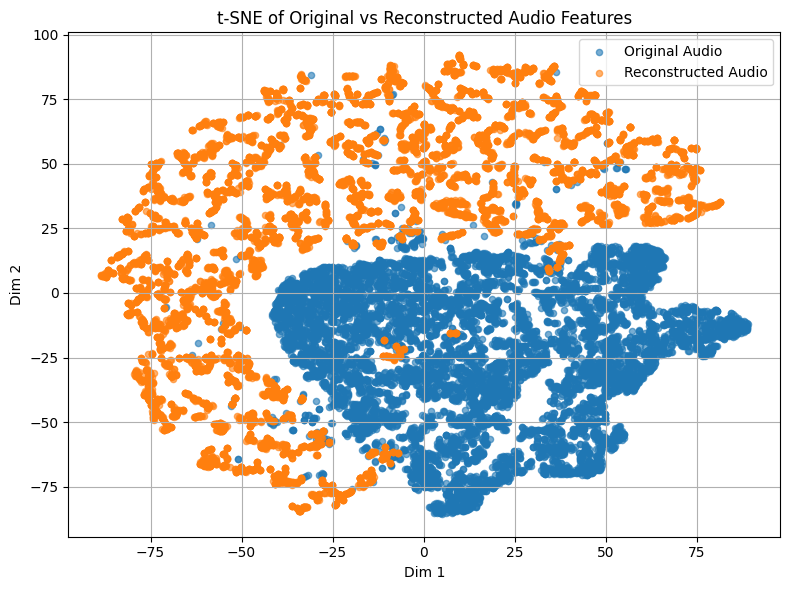

In [ ]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np
import os

# Directories for original and reconstructed audio features
original_dir = "/project/msoleyma_1026/personality_detection/first_impressions_v2_dataset/audio_feature_vectors/test"
recon_dir = "reconstructed_audio_feature_vectors"

original_feats = []
recon_feats = []

for fname in sorted(os.listdir(recon_dir)):
    if not fname.endswith(".npy"):
        continue

    sample_id = fname[:-4]
    orig_path = os.path.join(original_dir, fname)
    recon_path = os.path.join(recon_dir, fname)

    if not os.path.exists(orig_path):
        continue

    original = np.load(orig_path)
    original = original.mean(axis=1) # Shape: [5, 1024]
    recon = np.load(recon_path)    # Shape: [5, 1024]
    recon = recon.mean(axis=1)

    if original.shape != recon.shape:
        continue

    original_feats.extend(original)
    recon_feats.extend(recon)

# Combine and label
X = np.vstack([original_feats, recon_feats])  # [N*2, 1024]
y = np.array([0]*len(original_feats) + [1]*len(recon_feats))  # 0 = original, 1 = reconstructed

# t-SNE projection
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca', random_state=42)
X_2d = tsne.fit_transform(X)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(X_2d[y==0, 0], X_2d[y==0, 1], label="Original Audio", alpha=0.6, s=20)
plt.scatter(X_2d[y==1, 0], X_2d[y==1, 1], label="Reconstructed Audio", alpha=0.6, s=20)
plt.legend()
plt.title("t-SNE of Original vs Reconstructed Audio Features")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
!ls


 CS535_Faciel_Expression_Recognition.ipynb
'CVAE-2 (1).ipynb'
 Personality_Trait_Inference.ipynb
 README
 Untitled1.ipynb
 annotation_test.pkl
 annotation_test_filtered.pkl
 annotation_train_filtered.pkl
 annotation_training.pkl
 annotation_val_filtered.pkl
 annotation_validation.pkl
 cvae_audio_beta_anneal.pt
 cvae_visual_0.1.pt
 cvae_visual_beta_anneal.pt
 downstream.ipynb
 fer2013.bib
 fer20131.csv
 ferSubmission.csv
 ondemand
 reconstructed_audio_feature_vectors
 reconstructed_visual_feature_vectors
 scene.ipynb
 video_feature_vectors
